In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [2]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Define preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [4]:
def preprocess_text(text):
    """Preprocess text by converting to lowercase, removing punctuation/numbers, stopwords, and lemmatizing."""
    if not isinstance(text, str) or text.strip() == "":
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words) if words else ""

In [5]:
# Load the dataset
df = pd.read_csv('news.csv')

# Drop rows with missing values in title text or label
df = df.dropna(subset=['title', 'text', 'label'])

In [6]:
# Create 'combined' column
print("\nCreating 'combined' column...")
df['combined'] = df['title'] + ' [SEP] ' + df['text']
df['combined'] = df['combined'].apply(preprocess_text)


Creating 'combined' column...


In [7]:
# Check 'combined' column content
print("Sample of 'combined' after preprocessing:")
print(df['combined'].head())
print("Number of empty 'combined' entries:", (df['combined'] == "").sum())

Sample of 'combined' after preprocessing:
0    smell hillary fear sep daniel greenfield shill...
1    watch exact moment paul ryan committed politic...
2    kerry go paris gesture sympathy sep u secretar...
3    bernie supporter twitter erupt anger dnc tried...
4    battle new york primary matter sep primary day...
Name: combined, dtype: object
Number of empty 'combined' entries: 0


In [8]:
# Filter out rows with empty 'combined' after preprocessing
df = df[df['combined'] != ""]
print(f"Rows remaining after filtering empty 'combined': {len(df)}")

Rows remaining after filtering empty 'combined': 6335


In [9]:
# Apply LabelEncoder to 'label'
print("\nApplying LabelEncoder to 'label' column...")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])


Applying LabelEncoder to 'label' column...


In [10]:
# Check for missing values
print("Missing values in 'combined':", df['combined'].isnull().sum())
print("Missing values in 'label':", df['label'].isnull().sum())

Missing values in 'combined': 0
Missing values in 'label': 0


In [11]:
# TF-IDF Vectorization
print("\nVectorizing text data for Naive Bayes and Random Forest...")
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['combined'])
y = df['label']

print("Vocabulary size:", len(vectorizer.vocabulary_))


Vectorizing text data for Naive Bayes and Random Forest...


Vocabulary size: 5000


In [12]:
# Split the data for Naive Bayes and Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Train and evaluate Naive Bayes
print("\nTraining Naive Bayes model...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_report = classification_report(y_test, y_pred_nb, output_dict=True)
print("Naive Bayes Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Training Naive Bayes model...
Naive Bayes Results:
Accuracy: 0.8863456985003947
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       628
           1       0.90      0.87      0.89       639

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89      0.89      0.89      1267



In [14]:
# Train and evaluate Random Forest
print("\nTraining Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Training Random Forest model...
Random Forest Results:
Accuracy: 0.904498816101026
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       628
           1       0.91      0.90      0.90       639

    accuracy                           0.90      1267
   macro avg       0.90      0.90      0.90      1267
weighted avg       0.90      0.90      0.90      1267



In [15]:
# --- LSTM ---

# Prepare data for LSTM
print("\nPreparing data for LSTM...")
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['combined'])
sequences = tokenizer.texts_to_sequences(df['combined'])
max_sequence_length = 500
X_lstm = pad_sequences(sequences, maxlen=max_sequence_length)
y_lstm = df['label'].values


Preparing data for LSTM...


In [16]:
# Split the data for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

In [19]:
# Build and train LSTM model
print("\nTraining LSTM model...")
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=100, input_length=max_sequence_length))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_split=0.2, verbose=1)


Training LSTM model...


c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.6267 - loss: 0.6897 - val_accuracy: 0.7959 - val_loss: 0.4998
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8628 - loss: 0.3809 - val_accuracy: 0.8669 - val_loss: 0.3314
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9356 - loss: 0.1788 - val_accuracy: 0.8363 - val_loss: 0.3868
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9651 - loss: 0.1324 - val_accuracy: 0.8412 - val_loss: 0.4416
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9846 - loss: 0.0640 - val_accuracy: 0.8619 - val_loss: 0.5199
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9919 - loss: 0.0337 - val_accuracy: 0.8402 - val_loss: 0.5639
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9946 - loss: 0.0238 - val_accuracy: 0.8422 - val_loss: 0.6645
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9902 - loss: 0.0366 - val_accuracy: 0.8422 - val_loss:

In [20]:
# Evaluate LSTM
print("\nLSTM Results:")
y_pred_lstm = (lstm_model.predict(X_test_lstm, verbose=0) > 0.5).astype("int32")
lstm_accuracy = accuracy_score(y_test_lstm, y_pred_lstm)
lstm_report = classification_report(y_test_lstm, y_pred_lstm, output_dict=True)
print("Accuracy:", accuracy_score(y_test_lstm, y_pred_lstm))
print(classification_report(y_test_lstm, y_pred_lstm))


LSTM Results:
Accuracy: 0.8421468034727704
              precision    recall  f1-score   support

           0       0.86      0.81      0.84       628
           1       0.82      0.87      0.85       639

    accuracy                           0.84      1267
   macro avg       0.84      0.84      0.84      1267
weighted avg       0.84      0.84      0.84      1267




Plotting accuracy comparison...


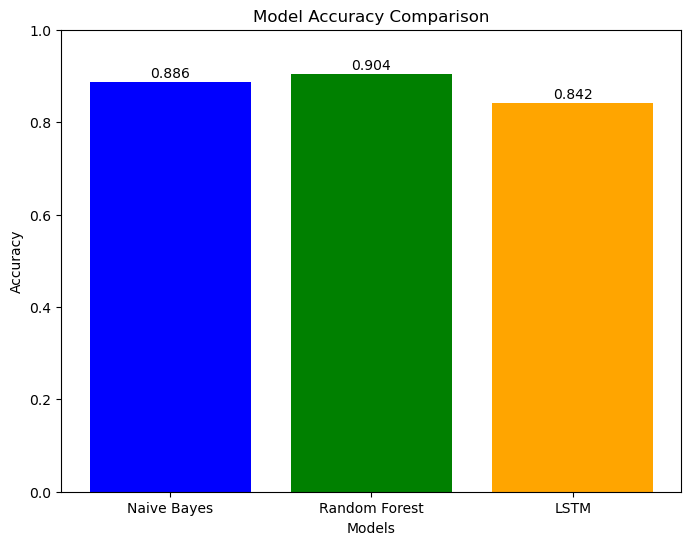

In [ ]:
import matplotlib.pyplot as plt

# Plotting Accuracy 
print("\nPlotting accuracy comparison...")
models = ['Naive Bayes', 'Random Forest', 'LSTM']
accuracies = [nb_accuracy, rf_accuracy, lstm_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')  
plt.show()


Plotting precision, recall, and F1-score comparison...


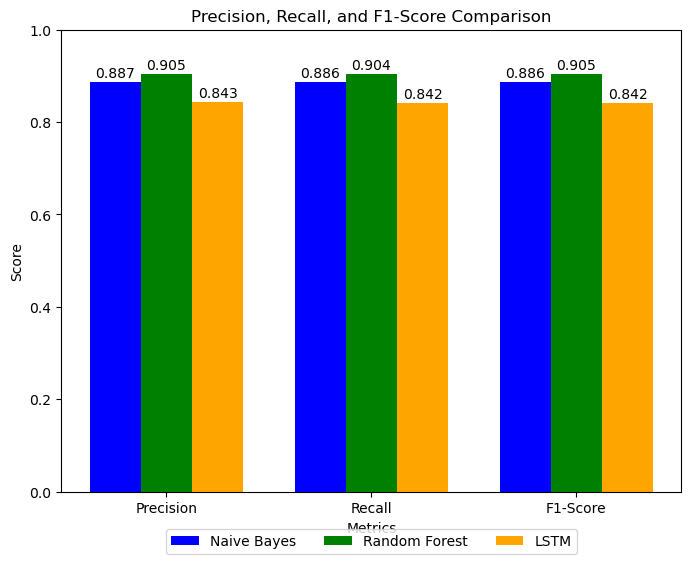

In [ ]:
# Plotting Precision, Recall, F1-Score 
print("\nPlotting precision, recall, and F1-score comparison...")

# Extract metrics from classification reports (using weighted avg for multi-class, or adjust for binary)
nb_precision = nb_report['weighted avg']['precision']
nb_recall = nb_report['weighted avg']['recall']
nb_f1 = nb_report['weighted avg']['f1-score']

rf_precision = rf_report['weighted avg']['precision']
rf_recall = rf_report['weighted avg']['recall']
rf_f1 = rf_report['weighted avg']['f1-score']

lstm_precision = lstm_report['weighted avg']['precision']
lstm_recall = lstm_report['weighted avg']['recall']
lstm_f1 = lstm_report['weighted avg']['f1-score']

# Data for plotting
metrics = ['Precision', 'Recall', 'F1-Score']
nb_metrics = [nb_precision, nb_recall, nb_f1]
rf_metrics = [rf_precision, rf_recall, rf_f1]
lstm_metrics = [lstm_precision, lstm_recall, lstm_f1]

# Set up the bar chart
bar_width = 0.25
index = np.arange(len(metrics))

plt.figure(figsize=(8, 6))
plt.bar(index, nb_metrics, bar_width, label='Naive Bayes', color='blue')
plt.bar(index + bar_width, rf_metrics, bar_width, label='Random Forest', color='green')
plt.bar(index + 2 * bar_width, lstm_metrics, bar_width, label='LSTM', color='orange')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score Comparison')
plt.xticks(index + bar_width, metrics)
plt.ylim(0, 1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Add value labels on top of bars
for i, v in enumerate(nb_metrics):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
for i, v in enumerate(rf_metrics):
    plt.text(i + bar_width, v + 0.01, f"{v:.3f}", ha='center')
for i, v in enumerate(lstm_metrics):
    plt.text(i + 2 * bar_width, v + 0.01, f"{v:.3f}", ha='center')

plt.show()

In [ ]:
# Prediction Function 
def predict_fake_news(title, text):
    """Predict if news is fake or real using trained models."""
    combined_input = title + ' [SEP] ' + text
    preprocessed_input = preprocess_text(combined_input)
    
    if preprocessed_input == "":
        return "Error: Input contains no valid words after preprocessing."

    # Naive Bayes and Random Forest prediction
    tfidf_input = vectorizer.transform([preprocessed_input])
    nb_pred = nb_model.predict(tfidf_input)[0]
    rf_pred = rf_model.predict(tfidf_input)[0]

    # LSTM prediction
    sequence = tokenizer.texts_to_sequences([preprocessed_input])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    lstm_pred = (lstm_model.predict(padded_sequence, verbose=0) > 0.5).astype("int32")[0][0]

    # Convert predictions to original labels
    nb_label = label_encoder.inverse_transform([nb_pred])[0]
    rf_label = label_encoder.inverse_transform([rf_pred])[0]
    lstm_label = label_encoder.inverse_transform([lstm_pred])[0]

    return {
        "Naive Bayes": nb_label,
        "Random Forest": rf_label,
        "LSTM": lstm_label
    }

In [33]:
# Example prediction
print("\nTesting prediction function...")
example_title = "Breaking News: Aliens Land in New York!"
example_text = "Scientists confirm extraterrestrial beings have arrived and are friendly."
predictions = predict_fake_news(example_title, example_text)
print("Predictions for example input:")
for model, pred in predictions.items():
    print(f"{model}: {pred}")


Testing prediction function...


Predictions for example input:
Naive Bayes: FAKE
Random Forest: FAKE
LSTM: FAKE


In [34]:
# Example prediction
print("\nTesting prediction function...")
example_title = "Egypt unveiled a $53 billion Gaza reconstruction plan with broad backing"
example_text = "Egypt unveiled a $53 billion Gaza reconstruction plan with broad backing that would not displace Palestinians. The White House says it ignores reality. The ambitious proposal aims to rebuild infrastructure destroyed in recent conflicts, focusing on housing, schools, and hospitals. Egyptian officials argue it’s a viable path to stability, supported by regional allies, but U.S. officials have expressed skepticism about its feasibility given ongoing political tensions."
predictions = predict_fake_news(example_title, example_text)
print("Predictions for example input:")
for model, pred in predictions.items():
    print(f"{model}: {pred}")


Testing prediction function...
Predictions for example input:
Naive Bayes: REAL
Random Forest: FAKE
LSTM: FAKE


###  1. Data Preprocessing

### Loading and Cleaning Data:

Loaded the dataset from news.csv using pandas.
Removed rows with missing values in the title, text, or label columns to ensure data quality.

### Text Preprocessing:

Created a combined column by merging title and text with a [SEP] separator.
Applied text cleaning steps:
Converted text to lowercase.
Removed punctuation and numbers.
Eliminated stopwords using NLTK.
Performed lemmatization to reduce words to their base forms.
Dropped rows where the combined column became empty after preprocessing.
Label Encoding:
Converted the label column (e.g., "fake" or "real") into numerical values using LabelEncoder for model compatibility.

## 2. Feature Extraction
For Naive Bayes and Random Forest:
Transformed the combined text into numerical features using TfidfVectorizer.
Limited the feature set to 5,000 maximum features to balance complexity and performance.
### For LSTM:
Tokenized the combined text using Keras' Tokenizer, restricting it to the top 5,000 words.
Padded sequences to a uniform length of 500 tokens to ensure consistent input for the LSTM model.

## 3. Model Training and Evaluation

### Data Splitting:
Divided the dataset into 80% training and 20% testing sets to evaluate model performance.
###  Model Training:

#### Naive Bayes:

Trained a MultinomialNB classifier using TF-IDF features.
#### Random Forest:
Trained a RandomForestClassifier with 100 estimators on TF-IDF features.

#### LSTM:

Built a sequential neural network with:
An Embedding layer.
An LSTM layer.
A Dense output layer.
Trained the model for 10 epochs.
#### Evaluation:

Measured performance using accuracy and detailed classification reports (precision, recall, F1-score) for each model.
## 4. Visualization

### Accuracy Comparison:

Created a bar chart to visually compare the accuracy of Naive Bayes, Random Forest, and LSTM models.
Precision, Recall, F1-Score Comparison:
Generated a grouped bar chart displaying the weighted average precision, recall, and F1-score across all three models.
## 5. Prediction Function
Implemented a predict_fake_news function to classify new text inputs using all three trained models (Naive Bayes, Random Forest, and LSTM).